In [2]:
import os
from os.path import join
import pickle
import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import gc
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, ConcatDataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import f1_score

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")


# Control Randomness
import random
random_seed = 7
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

# EDA & Cleaning

In [3]:
df=pd.read_pickle("LSWMD.pkl")

def removebrackets(array):
    if array.shape == (1, 1):
        return "".join(array[0])
    elif array.shape == (0, 0):
        return None
        
df.rename(columns = {'trianTestLabel':'TrainTestLabel'}, inplace = 'True')
df['TrainTestLabel'] = df['TrainTestLabel'].apply(removebrackets)
df['failureType'] = df['failureType'].apply(removebrackets)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   TrainTestLabel  172950 non-null  object 
 5   failureType     172950 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [4]:
df.sample(10)

,waferMap,dieSize,lotName,waferIndex,TrainTestLabel,failureType
489317,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,...",710.0,lot30277,11.0,None,None
604268,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot38064,16.0,None,None
582932,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot36387,15.0,None,None
314398,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4143.0,lot19167,25.0,None,None
584221,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot36447,19.0,None,None
13395,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",924.0,lot2114,13.0,None,None
636974,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot40093,22.0,None,None
518070,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot32396,20.0,None,None
252155,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1,...",518.0,lot15639,19.0,Training,none
695635,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1,...",736.0,lot42848,5.0,None,None


In [5]:
df.isna().sum()

waferMap               0
dieSize                0
lotName                0
waferIndex             0
TrainTestLabel    638507
failureType       638507
dtype: int64

In [6]:
df_ = df.TrainTestLabel.dropna()
# df_ = df_.failureType.dropna()
df_

0         Training
1         Training
2         Training
3         Training
4         Training
            ...   
811450        Test
811451        Test
811452        Test
811453        Test
811454        Test
Name: TrainTestLabel, Length: 172950, dtype: object

* The dataset were collected from **47,543 lots** in real-world fab. However, **47,543 lots x 25 wafer/lot =1,157,325 wafer maps** is larger than **811,457 wafer maps**. 

* Let's see what happened. 

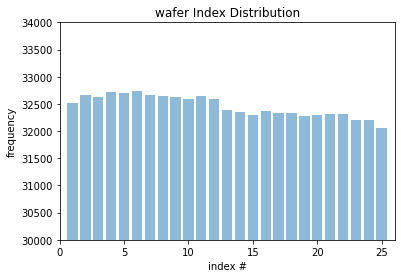

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0], uni_Index[1], align='center', alpha=0.5)
plt.title("wafer Index Distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [8]:
df = df.drop(['waferIndex'], axis = 1)

* We can not get much information from the wafer map column but we can see the die size for each instance is different. 

* We create a new variable **'waferMapDim'** for wafer map dim checking.

In [9]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0, dim1
    
df['waferMapDim']=df.waferMap.apply(find_dim)

In [10]:
df.sample(5)

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim
319117,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot19358,None,None,"(45, 43)"
476932,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot29465,None,None,"(49, 39)"
358138,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot21433,None,None,"(52, 59)"
211084,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",14116.0,lot13467,None,None,"(212, 84)"
373190,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",592.0,lot22287,None,None,"(29, 27)"


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   TrainTestLabel  172950 non-null  object 
 4   failureType     172950 non-null  object 
 5   waferMapDim     811457 non-null  object 
dtypes: float64(1), object(5)
memory usage: 37.1+ MB


In [12]:
df.shape[0]
# failureType: 811457 -> 172950

811457

In [13]:
df

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)"
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)"
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,None,None,"(26, 30)"


In [14]:
df_ = df.dropna(subset=['failureType'])

In [15]:
df_

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)"
...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)"
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)"
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)"
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)"


In [16]:
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [17]:
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]
# 632개의 서로다른 Wafer map size 가 존재.

632

In [18]:
df.groupby("waferMapDim").size().sort_values(ascending=False)[:20]

waferMapDim
(32, 29)    108687
(25, 27)     64083
(49, 39)     39323
(26, 26)     30078
(30, 34)     29513
(33, 33)     23886
(33, 29)     20276
(39, 37)     15327
(52, 59)     14812
(31, 31)     14569
(39, 31)     13562
(29, 26)     13247
(27, 25)     12655
(64, 71)     11692
(31, 28)     10788
(35, 40)     10676
(38, 38)      8895
(44, 44)      8601
(34, 31)      8155
(51, 59)      7890
dtype: int64

* The dimension of wafer map, or saying the **image size** are not always the same. We noticed that there are **632** different size for our wafer map. 

* For this reason, we must do **data tranformation** (feature extraction) to **make input the same dim** and the method will be introduced in the following section.

>**Missing value check**
* Do not be afraid to handle so large dataset. When you look into the dataset you may notice quite number of data are useless due to **missing values**.

* Do missing value check is an important part during data preparing process. Since we only interested in wafer with patterns, we may remove those data without failure type labels. 

In [19]:
df['failureNum']=df.failureType
df['trainTestNum']=df.TrainTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [20]:
df

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
...,...,...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)",3.0,1.0
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)",3.0,1.0
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,None,None,"(26, 30)",NaN,NaN


In [21]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

In [22]:
df_withlabel

,index,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
...,...,...,...,...,...,...,...,...,...
172945,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0
172946,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0
172947,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)",3.0,1.0
172948,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0


In [23]:
df_withpattern

,index,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,Loc,"(45, 48)",4.0,0.0
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)",2.0,0.0
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)",2.0,0.0
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)",2.0,0.0
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,Training,Edge-Loc,"(53, 58)",2.0,0.0
...,...,...,...,...,...,...,...,...,...
25514,811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0
25515,811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0
25516,811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,Edge-Ring,"(26, 30)",3.0,1.0
25517,811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,Test,Edge-Loc,"(26, 30)",2.0,1.0


In [24]:
df_nonpattern
# failuretype: none

,waferMap,dieSize,lotName,TrainTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,Training,none,"(45, 48)",8.0,0.0
...,...,...,...,...,...,...,...,...
811438,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,Test,none,"(26, 30)",8.0,1.0
811439,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,Test,none,"(26, 30)",8.0,1.0
811442,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,...",600.0,lot47542,Test,none,"(26, 30)",8.0,1.0
811445,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,Test,none,"(26, 30)",8.0,1.0


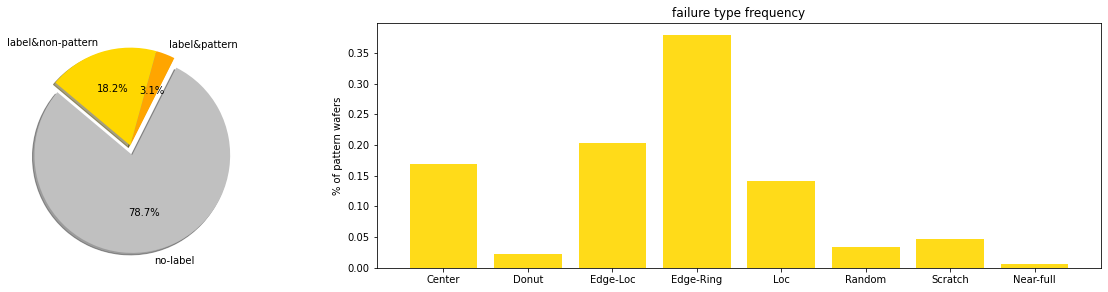

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
no_wafers=[df.shape[0]-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

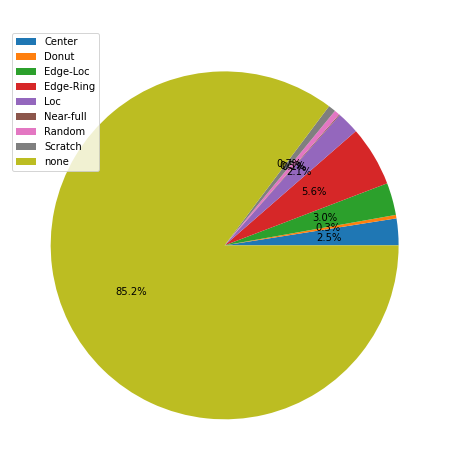

In [26]:
# with labeled - failuretype
label = df_withlabel.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

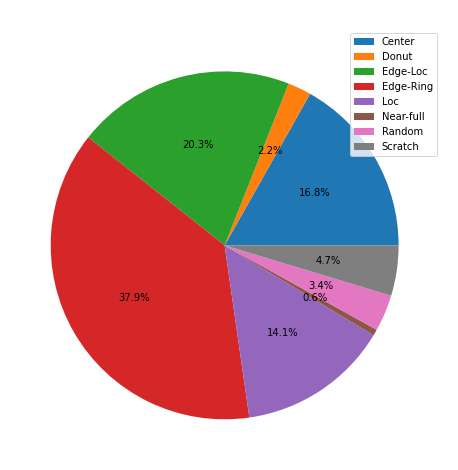

In [27]:
label = df_withpattern.failureType.values

plt.figure(figsize=(8, 8))
labels = np.unique(label, return_counts=True)[0]
counts = np.unique(label, return_counts=True)[1]

pie = plt.pie(x = counts, labels=labels, autopct = "%.1f%%")
_, texts, autotexts =pie
for items in texts:
    items.set_color('white') 
    items.set_fontsize('10')
for items in autotexts:
    items.set_fontsize('10')
plt.title('failureType', color = 'white', fontsize = 20)
plt.legend()
plt.show()

In [28]:
df_withpattern.failureType.value_counts()

Edge-Ring    9680
Edge-Loc     5189
Center       4294
Loc          3593
Scratch      1193
Random        866
Donut         555
Near-full     149
Name: failureType, dtype: int64

In [29]:
df_withpattern.waferMapDim[0][0]

45

In [30]:
def find_size(x):
    w = x[0]
    h = x[1]
    return np.sqrt(w*h)
    
df_withlabel['wafermaplen'] = df_withlabel.waferMapDim.apply(find_size)

In [31]:
print(df_withlabel.wafermaplen.median())
print(df_withlabel.wafermaplen.mean())

31.937438845342623
34.95293344628206


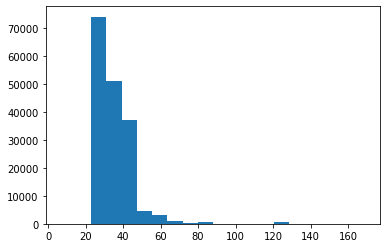

In [32]:
plt.hist(df_withlabel.wafermaplen, bins=20)
plt.show()

## Visualize

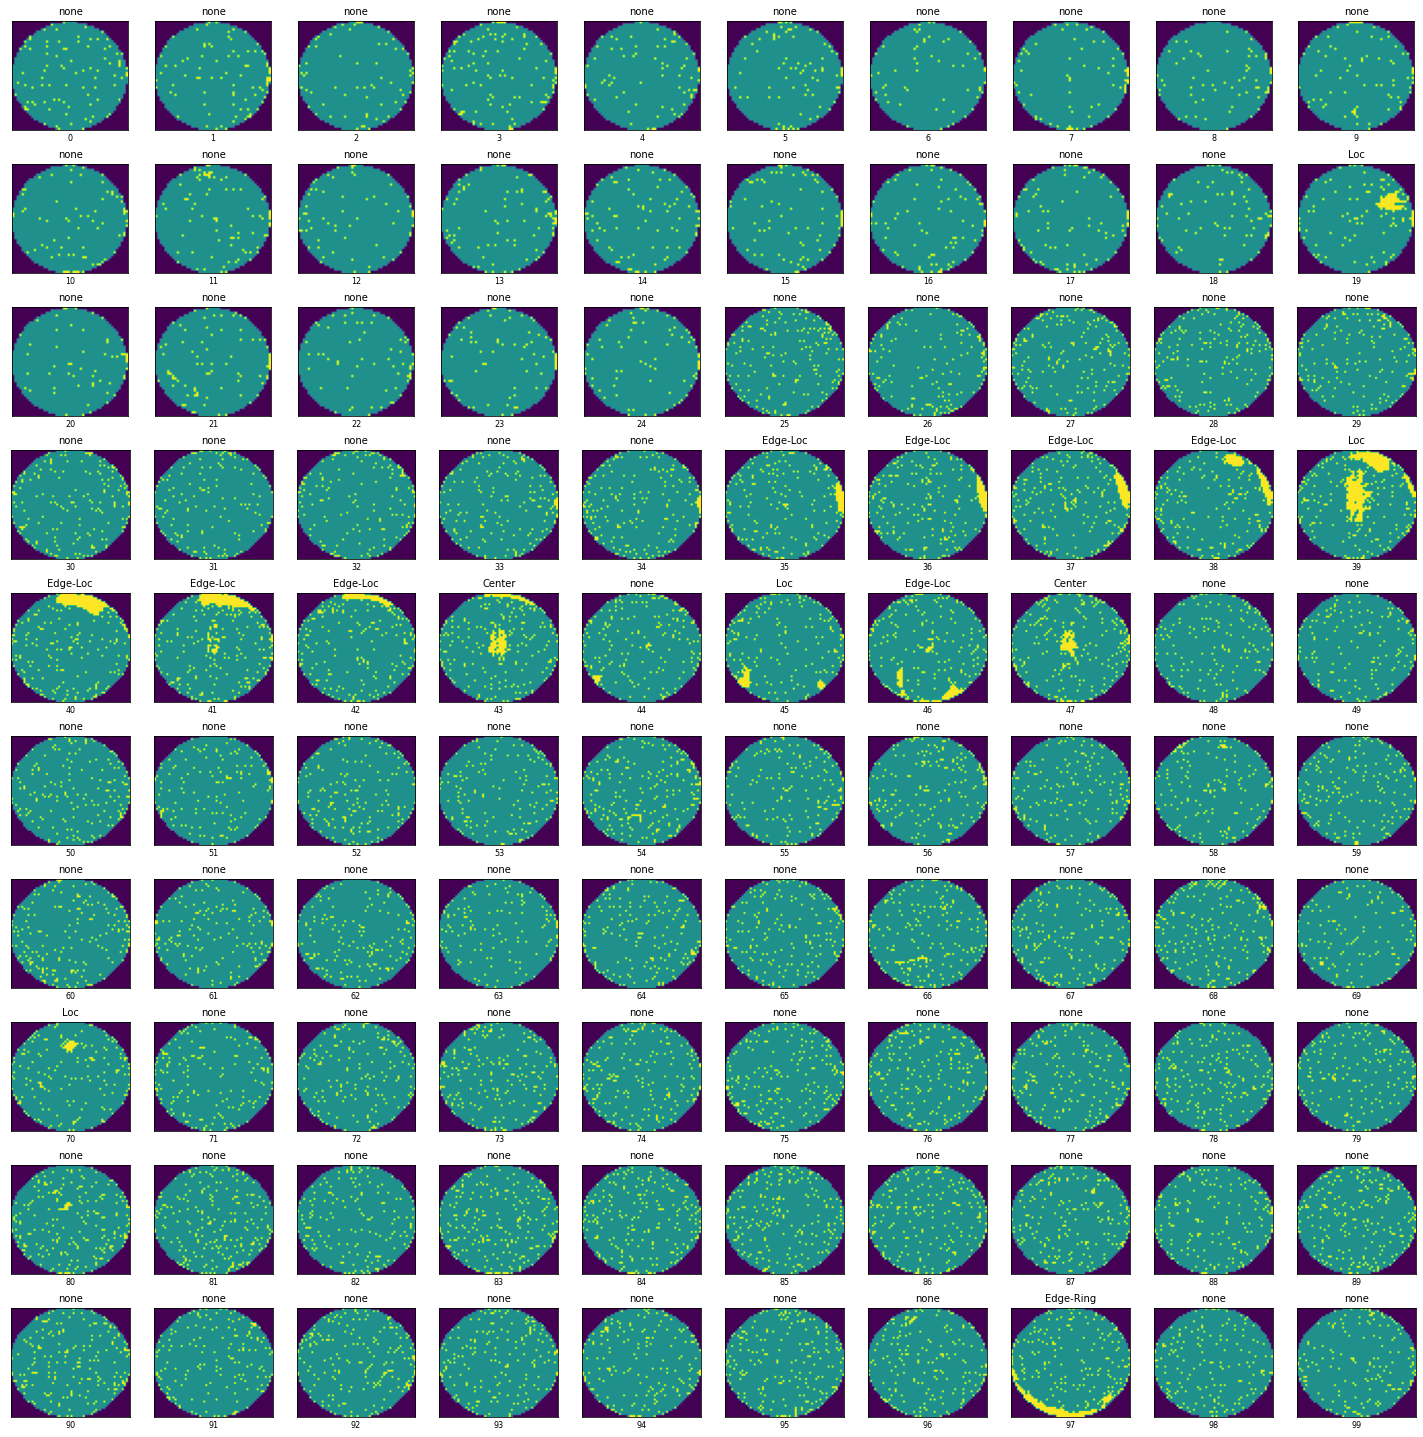

In [33]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withlabel.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withlabel.failureType[i], fontsize=10)
    ax[i].set_xlabel(df_withlabel.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

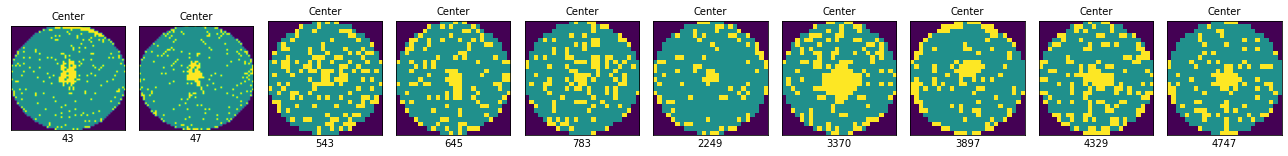

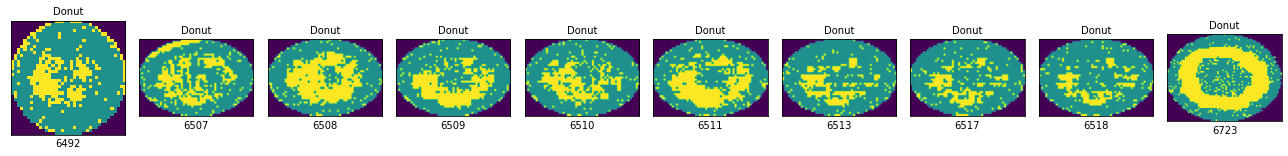

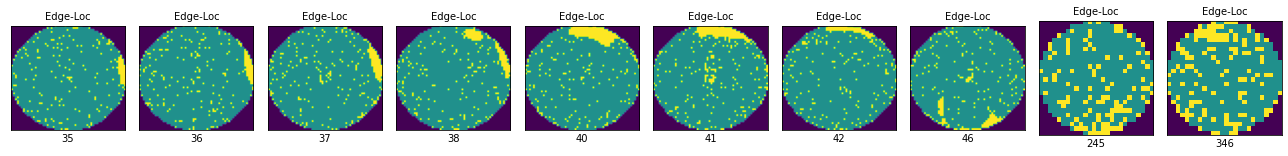

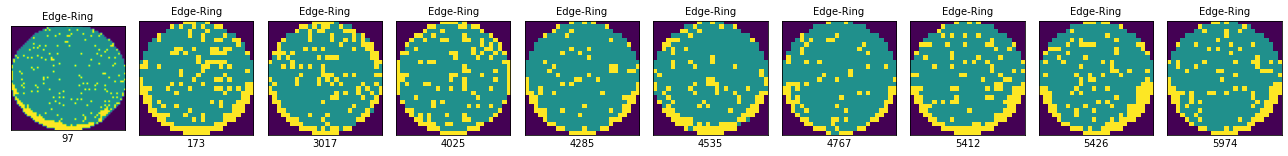

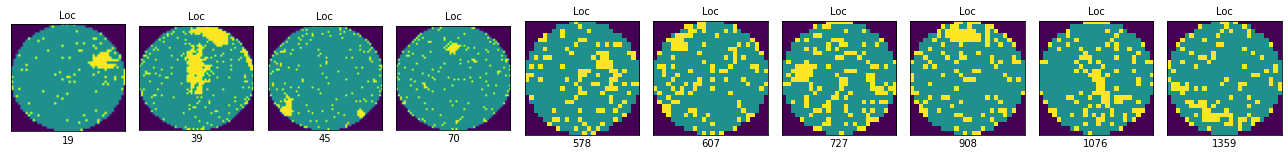

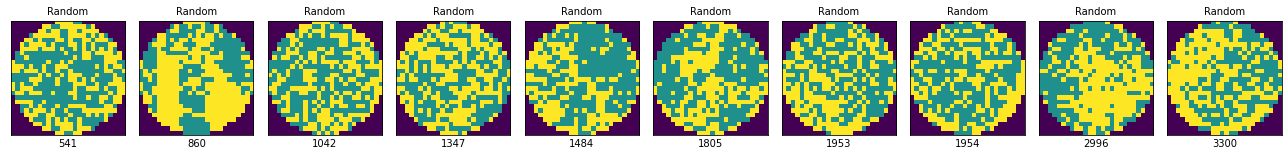

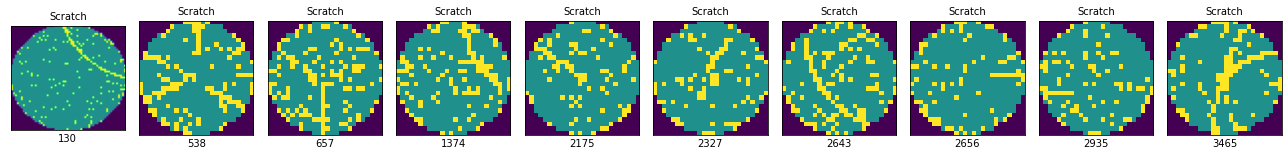

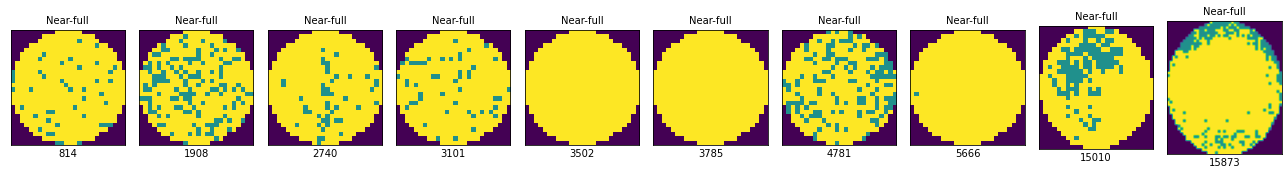

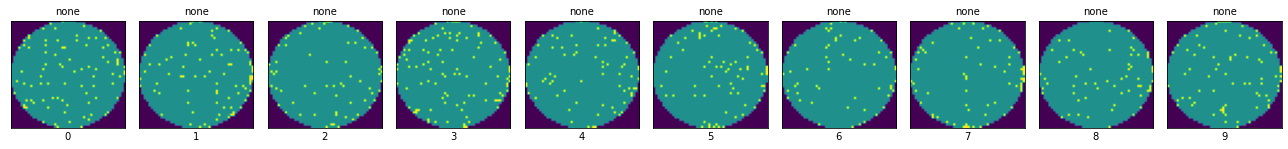

In [34]:
x = [0,1,2,3,4,5,6,7,8]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full','none']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel(order='C')
    for j in [k]:
        img = df_withlabel.waferMap[df_withlabel.failureType==labels2[j]]
        for i in range(10):
            ax[i].imshow(img[img.index[i]])
            ax[i].set_title(df_withlabel.failureType[img.index[i]], fontsize=10)
            ax[i].set_xlabel(df_withlabel.index[img.index[i]], fontsize=10)
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    plt.tight_layout()
    plt.show() 

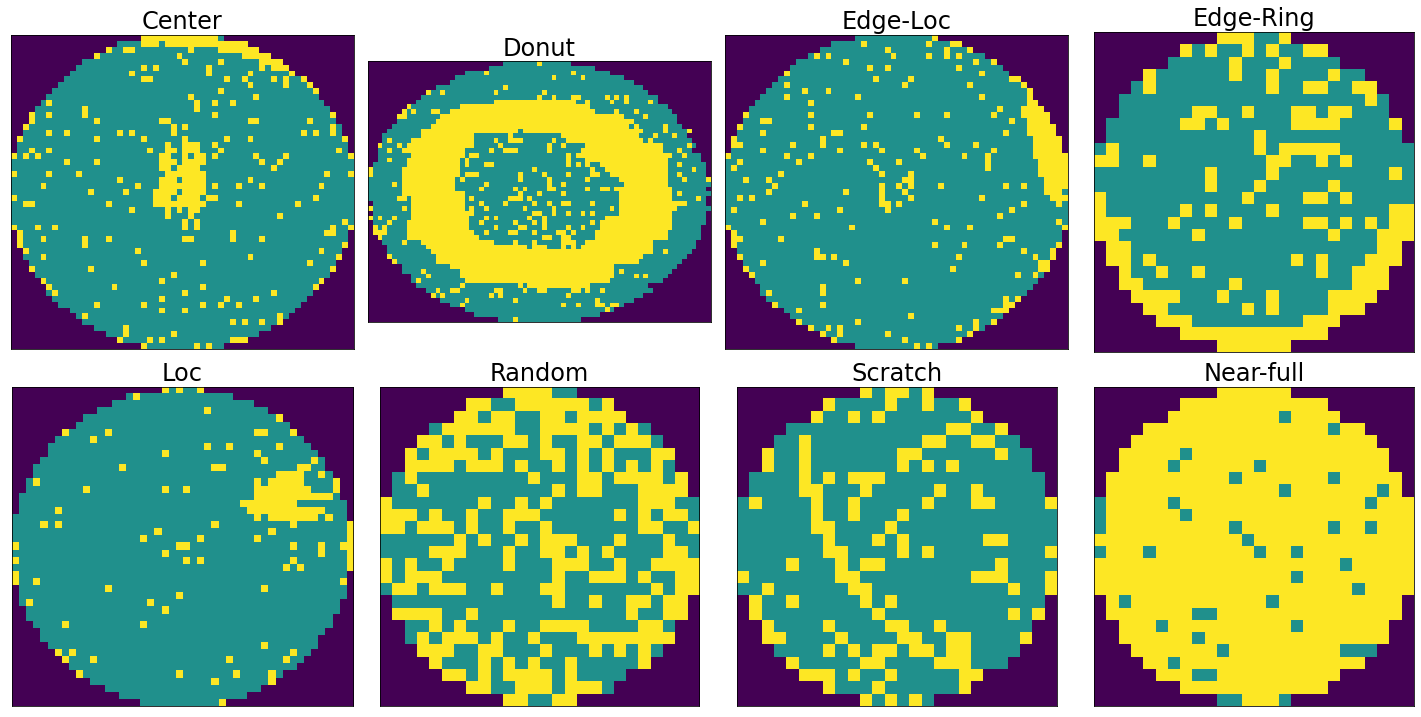

In [35]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

#ind_def = {'Center': 9, 'Donut': 340, 'Edge-Loc': 3, 'Edge-Ring': 16, 'Loc': 0, 'Random': 25,  'Scratch': 84, 'Near-full': 37}
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

In [36]:
df_withlabel.waferMap.values[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [37]:
df_withlabel.failureNum.values

array([8., 8., 8., ..., 3., 2., 3.])

In [38]:
X = df_withlabel.waferMap.values
y = df_withlabel.failureNum.values
assert X.shape[0] == y.shape[0]

In [39]:
df_withlabel.failureNum.unique()

array([8., 4., 2., 0., 3., 6., 5., 7., 1.])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

In [47]:
# Save
torch.save(X_train, 'Data/X_train.pt')
torch.save(X_val, 'Data/X_val.pt')
torch.save(X_test, 'Data/X_test.pt')
torch.save(y_train, 'Data/y_train.pt')
torch.save(y_val, 'Data/y_val.pt')
torch.save(y_test, 'Data/y_test.pt')

# Config

In [5]:
# Load
X_train = torch.load('Data/X_train.pt')
X_val = torch.load('Data/X_val.pt')
X_test = torch.load('Data/X_test.pt')
y_train = torch.load('Data/y_train.pt')
y_val = torch.load('Data/y_val.pt')
y_test = torch.load('Data/y_test.pt')

In [6]:
BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VAL = 128
BATCH_SIZE_TEST = 128

RE_SIZE = 96
INPUT_CH = 1    # Must be 1
NUM_CLASSES = 9
IS_PRETRAINED = False
LEARNING_RATE = 1e-4
EPOCHS = 50

save_name = 'baseline_resnet50'
save_path = f'models/{save_name}.pt'
device = torch.device("cuda:0")

# Dataset

In [7]:
from albumentations.pytorch.transforms import ToTensorV2
# Transforms and Dataset
class WaferDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        assert len(self.X) == len(self.y)
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        # X = self.df.waferMap.values[idx]
        # y = self.df.failureNum.values[idx].int()

        if self.transform:
            X = self.transform(image=X)
            
        return {
            'img' : X['image'], 
            'label': y
        }

transform = A.Compose([
    A.Resize(RE_SIZE, RE_SIZE, interpolation=cv2.INTER_AREA),
    ToTensorV2(),
])

train_dataset = WaferDataset(X_train, y_train, transform=transform)
val_dataset = WaferDataset(X_val, y_val, transform=transform)
test_dataset = WaferDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=False)

print(len(train_dataset), len(val_dataset), len(test_dataset))

121065 25942 25943


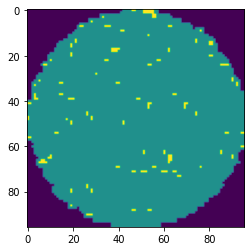

In [8]:
toimg = T.ToPILImage()
sample=next(iter(train_loader))['img'][np.random.randint(0, BATCH_SIZE_TRAIN)]
plt.imshow(np.asarray(sample[0]))
plt.show()

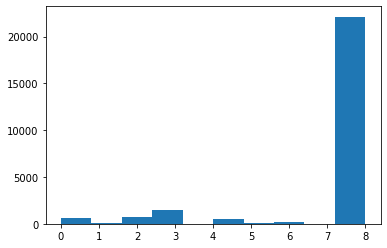

In [9]:
plt.hist(y_test)
plt.show()

# Model

In [11]:
from torchvision.models import resnet50
from torchinfo import summary

model = resnet50(pretrained=IS_PRETRAINED)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)
# summary(model, (BATCH_SIZE, INPUT_CH, RE_SIZE, RE_SIZE))

In [12]:

from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(reduction='mean')
# criterion = FocalLoss()
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, threshold=0.1, patience=10, threshold_mode='rel', verbose=True)

In [12]:
from sklearn.metrics import f1_score 

# def calc_f1(preds, labels):
#     preds = preds.detach().cpu().numpy()
#     labels = labels.cpu().numpy()
#     f1 = f1_score(preds, labels, average="weighted")
#     return f1

def train(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    # scaler = torch.cuda.amp.GradScaler()
    tqdm_loader = tqdm(enumerate(loader))
    model.train()
    # enumerate(tqdm(loader))
    for batch_idx, batch in tqdm_loader:
        img = batch['img']['image'].to(device)
        label = batch['label'].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # # mixed precision + gradient clipping
        # with torch.cuda.amp.autocast():
        #     output = model(img)
        #     loss = criterion(output, label)

        # scaler.scale(loss).backward() 
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
        # scaler.step(optimizer)
        # scaler.update()
        
        # forward + backward + optimize
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # stats
        preds = torch.argmax(output, dim=1)
        correct = torch.eq(preds, label).sum()
        running_loss += loss.item() 
        running_corrects += correct
        running_num += len(label)
        
        for item in label.cpu().numpy():
            y_true.append(item)
        for item in preds.cpu().numpy():
            y_pred.append(item)
        
        tqdm_loader.set_postfix({
            'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
            'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
            'Batch Loss': '{:06f}'.format(loss.item()),
            'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
            'Batch ACC': '{:06f}'.format(correct / len(label)),
            'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = running_corrects / running_num
    epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
    epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')

    writer.add_scalar('Loss/Train', epoch_loss, epoch)
    writer.add_scalar('Accuracy/Train', epoch_acc, epoch)
    writer.add_scalar('F1_macro/Train', epoch_f1_macro, epoch)
    writer.add_scalar('F1_weighted/Train', epoch_f1_weighted, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]["lr"], epoch)
    print(f'Train loss: {epoch_loss:.6f}, Train ACC: {epoch_acc:.6f}, F1_weighted: {epoch_f1_weighted:.6f} lr: {optimizer.param_groups[0]["lr"]:.6f}')
    
def evaluate(model, loader, epoch, nb_epochs):
    running_loss, running_corrects, running_num = 0.0, 0, 0
    y_true, y_pred = [], []
    tqdm_loader = tqdm(enumerate(loader))
    model.eval()

    with torch.no_grad():
        for batch_idx, batch in tqdm_loader:
            img = batch['img']['image'].to(device)
            label = batch['label'].to(device)#.long().to(device)

            output = model(img)
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_loss += loss.item() 
            running_corrects += correct
            running_num += len(label)

            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

            tqdm_loader.set_postfix({
                'Epoch': '{}/{}'.format(epoch + 1, nb_epochs),
                'Batch' : '{}/{}'.format(batch_idx + 1, len(loader)),
                'Batch Loss': '{:06f}'.format(loss.item()),
                'Mean Loss' : '{:06f}'.format(running_loss / (batch_idx + 1)),
                'Batch ACC': '{:06f}'.format(correct / len(label)),
                'Mean ACC' : '{:06f}'.format(running_corrects / running_num)
            })

        epoch_loss = running_loss / len(loader)
        epoch_acc = running_corrects / running_num
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        scheduler.step(epoch_loss)
        
        writer.add_scalar('Loss/Valid', epoch_loss, epoch)
        writer.add_scalar('Accuracy/Valid', epoch_acc, epoch)
        writer.add_scalar('F1_macro/Valid', epoch_f1_macro, epoch)
        writer.add_scalar('F1_weighted/Valid', epoch_f1_weighted, epoch)
        
        print(f'Valid loss: {epoch_loss:.6f}, Valid ACC: {epoch_acc:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')
        print(f'{running_corrects}/{running_num} correct')
        
        epoch_acc = epoch_acc.detach().cpu().numpy()    # tensor->numpy
        val_acc_list.append(epoch_acc)
        val_f1_weighted_list.append(epoch_f1_weighted)
        
        if np.max(val_acc_list) == val_acc_list[-1]:  # 현재 모델이 성능 최댓값이면 저장 
            torch.save(model.state_dict(), save_path)


# Train

In [13]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs/' + save_name)

val_acc_list = []
val_f1_weighted_list = []

model.to(device)

for epoch in range(EPOCHS):
    train(model, train_loader, epoch, EPOCHS)
    evaluate(model, val_loader, epoch, EPOCHS)

Epoch 1/50


100%|██████████| 3784/3784 [04:15<00:00, 14.79it/s]


Train loss: 0.186835, Train ACC: 0.946492, F1_macro: 0.594085, F1_weighted: 0.940610 lr: 0.000100
24883/25942 correct
Valid loss: 0.140169, Valid ACC: 0.959178, F1_macro: 0.647932, F1_weighted: 0.955170
Epoch 2/50


100%|██████████| 3784/3784 [04:12<00:00, 14.96it/s]


Train loss: 0.120035, Train ACC: 0.961872, F1_macro: 0.734050, F1_weighted: 0.958637 lr: 0.000100
24869/25942 correct
Valid loss: 0.135845, Valid ACC: 0.958638, F1_macro: 0.678903, F1_weighted: 0.957495
Epoch 3/50


100%|██████████| 3784/3784 [04:13<00:00, 14.93it/s]


Train loss: 0.102385, Train ACC: 0.965316, F1_macro: 0.773141, F1_weighted: 0.963009 lr: 0.000100
25070/25942 correct
Valid loss: 0.105823, Valid ACC: 0.966387, F1_macro: 0.759528, F1_weighted: 0.963464
Epoch 4/50


100%|██████████| 3784/3784 [04:13<00:00, 14.93it/s]


Train loss: 0.083210, Train ACC: 0.971478, F1_macro: 0.818811, F1_weighted: 0.970230 lr: 0.000100
25155/25942 correct
Valid loss: 0.091131, Valid ACC: 0.969663, F1_macro: 0.812138, F1_weighted: 0.968078
Epoch 5/50


100%|██████████| 3784/3784 [04:12<00:00, 14.97it/s]


Train loss: 0.067667, Train ACC: 0.976393, F1_macro: 0.856734, F1_weighted: 0.975782 lr: 0.000100
25124/25942 correct
Valid loss: 0.095499, Valid ACC: 0.968468, F1_macro: 0.834361, F1_weighted: 0.968666
Epoch 6/50


100%|██████████| 3784/3784 [04:16<00:00, 14.77it/s]


Train loss: 0.055537, Train ACC: 0.980275, F1_macro: 0.889159, F1_weighted: 0.979950 lr: 0.000100
25154/25942 correct
Valid loss: 0.095732, Valid ACC: 0.969625, F1_macro: 0.797515, F1_weighted: 0.969092
Epoch 7/50


100%|██████████| 3784/3784 [04:12<00:00, 15.00it/s]


Train loss: 0.044628, Train ACC: 0.984182, F1_macro: 0.912345, F1_weighted: 0.984012 lr: 0.000100
25179/25942 correct
Valid loss: 0.097026, Valid ACC: 0.970588, F1_macro: 0.836719, F1_weighted: 0.969567
Epoch 8/50


100%|██████████| 3784/3784 [04:11<00:00, 15.06it/s]


Train loss: 0.035795, Train ACC: 0.987230, F1_macro: 0.930592, F1_weighted: 0.987133 lr: 0.000100
25157/25942 correct
Valid loss: 0.097229, Valid ACC: 0.969740, F1_macro: 0.831426, F1_weighted: 0.970435
Epoch 9/50


100%|██████████| 3784/3784 [04:10<00:00, 15.10it/s]


Train loss: 0.030907, Train ACC: 0.988956, F1_macro: 0.939754, F1_weighted: 0.988890 lr: 0.000100
25076/25942 correct
Valid loss: 0.118747, Valid ACC: 0.966618, F1_macro: 0.837610, F1_weighted: 0.966843
Epoch 10/50


100%|██████████| 3784/3784 [04:09<00:00, 15.15it/s]


Train loss: 0.026366, Train ACC: 0.990460, F1_macro: 0.948274, F1_weighted: 0.990417 lr: 0.000100
25145/25942 correct
Valid loss: 0.131902, Valid ACC: 0.969278, F1_macro: 0.823909, F1_weighted: 0.968867
Epoch 11/50


100%|██████████| 3784/3784 [04:10<00:00, 15.08it/s]


Train loss: 0.022745, Train ACC: 0.991988, F1_macro: 0.956584, F1_weighted: 0.991961 lr: 0.000100
25192/25942 correct
Valid loss: 0.125400, Valid ACC: 0.971089, F1_macro: 0.852795, F1_weighted: 0.970572
Epoch 12/50


100%|██████████| 3784/3784 [04:12<00:00, 15.01it/s]


Train loss: 0.021158, Train ACC: 0.992591, F1_macro: 0.961427, F1_weighted: 0.992570 lr: 0.000100
25127/25942 correct
Valid loss: 0.130978, Valid ACC: 0.968584, F1_macro: 0.825086, F1_weighted: 0.968810
Epoch 13/50


100%|██████████| 3784/3784 [04:15<00:00, 14.80it/s]


Train loss: 0.019005, Train ACC: 0.993384, F1_macro: 0.958961, F1_weighted: 0.993366 lr: 0.000100
25196/25942 correct
Valid loss: 0.143361, Valid ACC: 0.971244, F1_macro: 0.828383, F1_weighted: 0.969989
Epoch 14/50


100%|██████████| 3784/3784 [04:09<00:00, 15.14it/s]


Train loss: 0.018251, Train ACC: 0.993557, F1_macro: 0.964574, F1_weighted: 0.993546 lr: 0.000100
25190/25942 correct
Valid loss: 0.128703, Valid ACC: 0.971012, F1_macro: 0.828120, F1_weighted: 0.969830
Epoch 15/50


100%|██████████| 3784/3784 [04:06<00:00, 15.33it/s]


Train loss: 0.016027, Train ACC: 0.994201, F1_macro: 0.962969, F1_weighted: 0.994192 lr: 0.000100
25163/25942 correct
Valid loss: 0.142979, Valid ACC: 0.969971, F1_macro: 0.825117, F1_weighted: 0.969163
Epoch 16/50


100%|██████████| 3784/3784 [04:05<00:00, 15.42it/s]


Train loss: 0.014508, Train ACC: 0.995052, F1_macro: 0.974365, F1_weighted: 0.995045 lr: 0.000100
25169/25942 correct
Valid loss: 0.131749, Valid ACC: 0.970203, F1_macro: 0.842752, F1_weighted: 0.970224
Epoch 17/50


100%|██████████| 3784/3784 [04:04<00:00, 15.46it/s]


Train loss: 0.014495, Train ACC: 0.995069, F1_macro: 0.972238, F1_weighted: 0.995061 lr: 0.000100
25209/25942 correct
Valid loss: 0.130488, Valid ACC: 0.971745, F1_macro: 0.846703, F1_weighted: 0.971029
Epoch 18/50


100%|██████████| 3784/3784 [04:08<00:00, 15.26it/s]


Train loss: 0.012494, Train ACC: 0.995696, F1_macro: 0.979166, F1_weighted: 0.995691 lr: 0.000100
25150/25942 correct
Valid loss: 0.140852, Valid ACC: 0.969470, F1_macro: 0.830419, F1_weighted: 0.969417
Epoch 19/50


100%|██████████| 3784/3784 [04:07<00:00, 15.31it/s]


Train loss: 0.012376, Train ACC: 0.995812, F1_macro: 0.976897, F1_weighted: 0.995809 lr: 0.000100
25228/25942 correct
Valid loss: 0.141098, Valid ACC: 0.972477, F1_macro: 0.844664, F1_weighted: 0.971782
Epoch 20/50


100%|██████████| 3784/3784 [04:05<00:00, 15.43it/s]


Train loss: 0.012012, Train ACC: 0.995944, F1_macro: 0.980561, F1_weighted: 0.995939 lr: 0.000100
25219/25942 correct
Valid loss: 0.147899, Valid ACC: 0.972130, F1_macro: 0.858121, F1_weighted: 0.971637
Epoch 21/50


100%|██████████| 3784/3784 [04:06<00:00, 15.35it/s]


Train loss: 0.011382, Train ACC: 0.996068, F1_macro: 0.978172, F1_weighted: 0.996064 lr: 0.000100
25187/25942 correct
Valid loss: 0.143579, Valid ACC: 0.970897, F1_macro: 0.839903, F1_weighted: 0.970659
Epoch 22/50


100%|██████████| 3784/3784 [04:06<00:00, 15.38it/s]


Train loss: 0.010948, Train ACC: 0.996374, F1_macro: 0.982888, F1_weighted: 0.996371 lr: 0.000100
25234/25942 correct
Valid loss: 0.145974, Valid ACC: 0.972708, F1_macro: 0.859243, F1_weighted: 0.972012
Epoch 23/50


100%|██████████| 3784/3784 [04:06<00:00, 15.32it/s]


Train loss: 0.010050, Train ACC: 0.996613, F1_macro: 0.982326, F1_weighted: 0.996608 lr: 0.000100
25221/25942 correct
Valid loss: 0.136023, Valid ACC: 0.972207, F1_macro: 0.853052, F1_weighted: 0.971746
Epoch 24/50


100%|██████████| 3784/3784 [04:12<00:00, 14.96it/s]


Train loss: 0.009488, Train ACC: 0.996878, F1_macro: 0.985094, F1_weighted: 0.996874 lr: 0.000100
25225/25942 correct
Valid loss: 0.153424, Valid ACC: 0.972361, F1_macro: 0.852161, F1_weighted: 0.971458
Epoch 25/50


100%|██████████| 3784/3784 [04:09<00:00, 15.18it/s]


Train loss: 0.009823, Train ACC: 0.996704, F1_macro: 0.983991, F1_weighted: 0.996700 lr: 0.000100
25187/25942 correct
Valid loss: 0.161525, Valid ACC: 0.970897, F1_macro: 0.832459, F1_weighted: 0.970316
Epoch 26/50


100%|██████████| 3784/3784 [04:08<00:00, 15.24it/s]


Train loss: 0.008824, Train ACC: 0.996919, F1_macro: 0.982715, F1_weighted: 0.996916 lr: 0.000100
25164/25942 correct
Valid loss: 0.168008, Valid ACC: 0.970010, F1_macro: 0.840651, F1_weighted: 0.969464
Epoch 27/50


100%|██████████| 3784/3784 [04:10<00:00, 15.12it/s]


Train loss: 0.008096, Train ACC: 0.997142, F1_macro: 0.984842, F1_weighted: 0.997141 lr: 0.000100
25207/25942 correct
Valid loss: 0.150097, Valid ACC: 0.971668, F1_macro: 0.846692, F1_weighted: 0.971146
Epoch 28/50


100%|██████████| 3784/3784 [04:09<00:00, 15.17it/s]


Train loss: 0.007888, Train ACC: 0.997406, F1_macro: 0.986808, F1_weighted: 0.997406 lr: 0.000100
25196/25942 correct
Valid loss: 0.170699, Valid ACC: 0.971244, F1_macro: 0.831465, F1_weighted: 0.970134
Epoch 29/50


100%|██████████| 3784/3784 [04:09<00:00, 15.19it/s]


Train loss: 0.008328, Train ACC: 0.997324, F1_macro: 0.987312, F1_weighted: 0.997323 lr: 0.000100
25228/25942 correct
Valid loss: 0.166892, Valid ACC: 0.972477, F1_macro: 0.852931, F1_weighted: 0.971449
Epoch 30/50


100%|██████████| 3784/3784 [04:09<00:00, 15.18it/s]


Train loss: 0.007766, Train ACC: 0.997315, F1_macro: 0.987734, F1_weighted: 0.997314 lr: 0.000100
25204/25942 correct
Valid loss: 0.168856, Valid ACC: 0.971552, F1_macro: 0.852812, F1_weighted: 0.971321
Epoch 31/50


100%|██████████| 3784/3784 [04:08<00:00, 15.20it/s]


Train loss: 0.007203, Train ACC: 0.997572, F1_macro: 0.989424, F1_weighted: 0.997571 lr: 0.000100
25242/25942 correct
Valid loss: 0.155170, Valid ACC: 0.973017, F1_macro: 0.848501, F1_weighted: 0.972426
Epoch 32/50


100%|██████████| 3784/3784 [04:09<00:00, 15.16it/s]


Train loss: 0.007537, Train ACC: 0.997373, F1_macro: 0.984955, F1_weighted: 0.997371 lr: 0.000100
25156/25942 correct
Valid loss: 0.165411, Valid ACC: 0.969702, F1_macro: 0.850256, F1_weighted: 0.969634
Epoch 33/50


100%|██████████| 3784/3784 [04:09<00:00, 15.15it/s]


Train loss: 0.006973, Train ACC: 0.997613, F1_macro: 0.986342, F1_weighted: 0.997612 lr: 0.000100
25207/25942 correct
Valid loss: 0.165878, Valid ACC: 0.971668, F1_macro: 0.852812, F1_weighted: 0.971177
Epoch 34/50


100%|██████████| 3784/3784 [04:09<00:00, 15.14it/s]


Train loss: 0.006554, Train ACC: 0.997745, F1_macro: 0.989947, F1_weighted: 0.997743 lr: 0.000100
25253/25942 correct
Valid loss: 0.175604, Valid ACC: 0.973441, F1_macro: 0.855864, F1_weighted: 0.972199
Epoch 35/50


100%|██████████| 3784/3784 [04:09<00:00, 15.14it/s]


Train loss: 0.007343, Train ACC: 0.997555, F1_macro: 0.985672, F1_weighted: 0.997554 lr: 0.000100
25255/25942 correct
Valid loss: 0.156407, Valid ACC: 0.973518, F1_macro: 0.855058, F1_weighted: 0.972671
Epoch 36/50


100%|██████████| 3784/3784 [04:11<00:00, 15.05it/s]


Train loss: 0.006384, Train ACC: 0.998001, F1_macro: 0.985333, F1_weighted: 0.998001 lr: 0.000100
25218/25942 correct
Valid loss: 0.176590, Valid ACC: 0.972092, F1_macro: 0.849787, F1_weighted: 0.971060
Epoch 37/50


100%|██████████| 3784/3784 [04:10<00:00, 15.13it/s]


Train loss: 0.006407, Train ACC: 0.997819, F1_macro: 0.990720, F1_weighted: 0.997818 lr: 0.000100
25215/25942 correct
Valid loss: 0.171628, Valid ACC: 0.971976, F1_macro: 0.845798, F1_weighted: 0.971170
Epoch 38/50


100%|██████████| 3784/3784 [04:17<00:00, 14.70it/s]


Train loss: 0.005493, Train ACC: 0.998191, F1_macro: 0.993815, F1_weighted: 0.998191 lr: 0.000100
25250/25942 correct
Valid loss: 0.166984, Valid ACC: 0.973325, F1_macro: 0.858258, F1_weighted: 0.972089
Epoch 39/50


100%|██████████| 3784/3784 [04:14<00:00, 14.88it/s]


Train loss: 0.005661, Train ACC: 0.998042, F1_macro: 0.990699, F1_weighted: 0.998042 lr: 0.000100
25192/25942 correct
Valid loss: 0.168634, Valid ACC: 0.971089, F1_macro: 0.852848, F1_weighted: 0.970947
Epoch 40/50


100%|██████████| 3784/3784 [04:12<00:00, 15.00it/s]


Train loss: 0.006464, Train ACC: 0.997844, F1_macro: 0.989384, F1_weighted: 0.997843 lr: 0.000100
25159/25942 correct
Valid loss: 0.179972, Valid ACC: 0.969817, F1_macro: 0.839315, F1_weighted: 0.969250
Epoch 41/50


100%|██████████| 3784/3784 [04:13<00:00, 14.95it/s]


Train loss: 0.005300, Train ACC: 0.998356, F1_macro: 0.988655, F1_weighted: 0.998356 lr: 0.000100
25070/25942 correct
Valid loss: 0.172413, Valid ACC: 0.966387, F1_macro: 0.828678, F1_weighted: 0.967409
Epoch 42/50


100%|██████████| 3784/3784 [04:11<00:00, 15.06it/s]


Train loss: 0.005848, Train ACC: 0.997976, F1_macro: 0.987975, F1_weighted: 0.997976 lr: 0.000100
25196/25942 correct
Valid loss: 0.195037, Valid ACC: 0.971244, F1_macro: 0.843255, F1_weighted: 0.970420
Epoch 43/50


100%|██████████| 3784/3784 [04:09<00:00, 15.17it/s]


Train loss: 0.005604, Train ACC: 0.998166, F1_macro: 0.992254, F1_weighted: 0.998166 lr: 0.000100


In [1]:
max_score = np.max(val_f1_weighted_list)
print(max_score)

NameError: name 'np' is not defined

# Test

In [ ]:
def test(model, loader):
    running_loss = 0.0
    running_f1 = 0.0
    running_corrects = 0
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for idx, batch in enumerate(tqdm(loader)):
            img = batch['img'].float().to(device)
            label = batch['label'].long().to(device)

            output = model(img)
            loss = criterion(output, label)

            # stats
            preds = torch.argmax(output, dim=1)
            correct = torch.eq(preds, label).sum()
            running_loss += loss.item() 
            running_corrects+=correct
    
            for item in label.cpu().numpy():
                y_true.append(item)
            for item in preds.cpu().numpy():
                y_pred.append(item)

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = running_corrects / len(loader.dataset)
        epoch_f1_macro = f1_score(y_true, y_pred, average='macro')
        epoch_f1_weighted = f1_score(y_true, y_pred, average='weighted')
        
        print(f'{running_corrects}/{len(loader.dataset)} correct')
        print(f'Test loss: {epoch_loss:.6f}, Test ACC: {epoch_acc:.6f}, F1_macro: {epoch_f1_macro:.6f}, F1_weighted: {epoch_f1_weighted:.6f}')


In [14]:
from torchvision.models import resnet50
import torch.nn as nn 

model = resnet50(pretrained=False)
model.conv1 = nn.Conv2d(INPUT_CH, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
feat = model.fc.in_features
model.fc = nn.Linear(feat, NUM_CLASSES)

# LOAD trained model 
model.load_state_dict(torch.load(save_path))
model.to(device)
test(model, test_loader)

100%|██████████| 203/203 [00:05<00:00, 34.24it/s]

25213/25943 correct
Test loss: 0.140606, Test ACC: 0.971861, F1_macro: 0.856986, F1_weighted: 0.971209


In [ ]:
val_y_true = []
val_y_pred = []

with torch.no_grad():
    for idx, batch in enumerate(tqdm(val_dataloader)):
        img = batch['img'].float().to(device)
        label = batch['label'].long().to(device)
        output = model(img)
        preds = torch.argmax(output, dim=1)
        
        for item in label.cpu().numpy():
            val_y_true.append(item)
        for item in preds.cpu().numpy():
            val_y_pred.append(item)

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(30, 30))
sns.heatmap(
    confusion_matrix(
        val_y_true,
        val_y_pred,
        normalize = 'true'), 
        annot=True, cmap='coolwarm'
        )
plt.title("CONFUSION MATRIX of the val dataset", fontsize=25)
plt.show()